In [2]:
import sys

sys.path.append("C:/Users/11581/UU/mobile_phone")

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plts
from shapely.geometry import Point
import pandas as pd
import warnings
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.")
from sklearn.preprocessing import MinMaxScaler, StandardScaler, quantile_transform
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import shap
import random
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [194]:
long_flow = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/longtermdisplacement.csv')
short_flow = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/shorttermdisplacement.csv')
sci = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/sci.csv')

city = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/city.csv')
city_distance = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/city_distance.csv')

districts_gdf = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/districts_gdf.csv')
district_distance = pd.read_csv('C:/Users/11581/OneDrive/桌面/data/district_distance.csv')
radiation_features = pd.read_csv('C:/Users/11581/OneDrive/桌面/dataset/radiation_features.csv')

In [195]:
baseline_weeks = short_flow[short_flow['week'].isin(['2023-01-23/2023-01-29', '2023-01-30/2023-02-05'])]

In [196]:
baseline_weeks_t = baseline_weeks[(baseline_weeks['segment'] == 1.0)]
baseline_weeks_s = baseline_weeks[(baseline_weeks['segment'] == 2.0)]

In [198]:
baseline_t = baseline_weeks_t.groupby(['week', 'origin_city_district', 'destination_city_district'], as_index=False)['flow_count'].sum()
baseline_s = baseline_weeks_s.groupby(['week', 'origin_city_district', 'destination_city_district'], as_index=False)['flow_count'].sum()

In [199]:
third_weeks = short_flow[short_flow['week'].isin([ '2023-02-06/2023-02-12'])]

third_weeks_t = third_weeks[third_weeks['segment'] == 1 ]
third_weeks_s = third_weeks[third_weeks['segment'] == 2 ]

In [200]:
merged_t = third_weeks_t.merge(baseline_t, on=['origin_city_district', 'destination_city_district'], how='left')
merged_s = third_weeks_s.merge(baseline_s, on=['origin_city_district', 'destination_city_district'], how='left')

In [202]:
merged_t['flow_difference'] = merged_t.apply(
    lambda row: max(0, row['flow_count_x'] - row['flow_count_y']) 
    if pd.notna(row['flow_count_y']) 
    else row['flow_count_x'], axis=1
)

merged_s['flow_difference'] = merged_s.apply(
    lambda row: max(0, row['flow_count_x'] - row['flow_count_y']) 
    if pd.notna(row['flow_count_y']) 
    else row['flow_count_x'], axis=1
)

In [204]:
merged_t['city_1'] = merged_t['origin_city_district'].str.split('_').str[0]
merged_s['city_1'] = merged_s['origin_city_district'].str.split('_').str[0]
merged_t['city_2'] = merged_t['destination_city_district'].str.split('_').str[0]
merged_s['city_2'] = merged_s['destination_city_district'].str.split('_').str[0]

merged_t = merged_t.groupby(['city_1','city_2'], as_index=False).agg({'flow_difference': 'sum'})
merged_s = merged_s.groupby(['city_1','city_2'], as_index=False).agg({'flow_difference': 'sum'})


In [206]:
merged_t = pd.merge(
    merged_t, 
    city[['city', 'intensity']], 
    left_on='city_1', 
    right_on='city', 
    how='left'
)
merged_s = pd.merge(
    merged_s, 
    city[['city', 'intensity']], 
    left_on='city_1', 
    right_on='city', 
    how='left'
)

flow_t = merged_t[merged_t['intensity'] > 4.5]
flow_s = merged_s[merged_s['intensity'] > 4.5]

flow_t['flow_count'] = np.ceil(flow_t['flow_difference'])
flow_s['flow_count'] = np.ceil(flow_s['flow_difference'])


C:\Users\11581\AppData\Local\Temp\ipykernel_14712\2072090111.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_t['flow_count'] = np.ceil(flow_t['flow_difference'])
C:\Users\11581\AppData\Local\Temp\ipykernel_14712\2072090111.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_s['flow_count'] = np.ceil(flow_s['flow_difference'])


In [209]:
sci = sci[['user_loc', 'fr_loc', 'scaled_sci']]
sci.columns = ['city_1', 'city_2', 'sci']

print(sci)

          city_1    city_2      sci
0       ISTANBUL  ISTANBUL    39928
1       TEKIRDAG  ISTANBUL    20076
2         EDIRNE  ISTANBUL    19540
3     KIRKLARELI  ISTANBUL    19548
4      BALIKESIR  ISTANBUL    10571
...          ...       ...      ...
6556  DIYARBAKIR     SIIRT    27162
6557      MARDIN     SIIRT    20697
6558      BATMAN     SIIRT   116631
6559      SIRNAK     SIIRT    60993
6560       SIIRT     SIIRT  3341911

[6561 rows x 3 columns]


In [210]:


city_distance['category'] = city_distance['distance'].apply(
    lambda x: 2 if 0 <= x <= 100 else
               3 if 100 < x <= 200 else
               4 if x > 200 else None  

self_relations = city_distance[['city_1']].drop_duplicates()  
self_relations['city_2'] = self_relations['city_1']
self_relations['distance'] = 50  
self_relations['category'] = 1 

city_distance = pd.concat([city_distance, self_relations], ignore_index=True)

print(city_distance)

      Unnamed: 0   city_1          city_2    distance  category
0            0.0    ADANA        ADIYAMAN  306.975739         4
1            1.0    ADANA  AFYONKARAHISAR  575.641564         4
2            2.0    ADANA            AGRI  906.896062         4
3            3.0    ADANA         AKSARAY  243.291838         4
4            4.0    ADANA          AMASYA  474.205383         4
...          ...      ...             ...         ...       ...
3315         NaN  TUNCELI         TUNCELI   50.000000         1
3316         NaN     USAK            USAK   50.000000         1
3317         NaN      VAN             VAN   50.000000         1
3318         NaN   YALOVA          YALOVA   50.000000         1
3319         NaN   YOZGAT          YOZGAT   50.000000         1

[3320 rows x 5 columns]


In [211]:
city_distance['distance_zscore'] = (city_distance['distance'] - city_distance['distance'].mean()) / city_distance['distance'].std()

city_distance['distance_log'] = 1 / (1 + np.exp(-city_distance['distance_zscore']))

In [212]:
#normalizing

def apply_minmax(df, columns, district_columns=['district_1', 'district_2']):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)
    return pd.concat([df[district_columns].copy(), df_scaled], axis=1)

def apply_zscore(df, columns, district_columns=['district_1', 'district_2']):
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)
    return pd.concat([df[district_columns].copy(), df_scaled], axis=1)

def apply_logistic_zscore(df, columns, district_columns=['district_1', 'district_2']):
    zscore_scaled = apply_zscore(df, columns, district_columns)[columns]  
    logistic_scaled = 1 / (1 + np.exp(-zscore_scaled)) 
    return pd.concat([df[district_columns].copy(), logistic_scaled], axis=1)

def apply_percentile(df, columns, district_columns=['district_1', 'district_2']):
    percentile_scaled = pd.DataFrame(quantile_transform(df[columns], output_distribution='uniform'), columns=columns)
    return pd.concat([df[district_columns].copy(), percentile_scaled], axis=1)


In [213]:
# normalizing districts_gdf
columns_to_normalize = ['healthcare', 'damaged_buildings_ratio', 'population', 'intensity', 'rwi','turks','syrian']


city_gdf_maxmin = apply_minmax(city, columns_to_normalize,['city'])
city_gdf_zscore = apply_zscore(city, columns_to_normalize,['city'])
city_gdf_log = apply_logistic_zscore(city, columns_to_normalize,['city'])
city_gdf_percentile = apply_percentile(city, columns_to_normalize,['city'])

print("Min-Max Normalization:\n", city_gdf_maxmin.head())
#print("Z-Score Normalization:\n", city_gdf_zscore.head())
#print("Logistic Z-Score Normalization:\n", city_gdf_log.head())
#print("Percentile Normalization:\n", city_gdf_percentile.head())

Min-Max Normalization:
         city  healthcare  damaged_buildings_ratio  population  intensity  \
0   ISTANBUL    1.000000                 0.000000    1.000000   0.000000   
1  GAZIANTEP    0.034682                 0.513061    0.133468   0.816901   
2  SANLIURFA    0.031792                 0.291669    0.136669   0.746479   
3      HATAY    0.049133                 0.518582    0.093680   0.760563   
4      ADANA    0.063584                 0.326868    0.140287   0.845070   

        rwi     turks    syrian  
0  1.000000  1.000000  1.000000  
1  0.228830  0.109732  0.815867  
2  0.171803  0.120776  0.597185  
3  0.335196  0.077542  0.561683  
4  0.110657  0.129709  0.450452  


C:\Users\11581\anaconda3\envs\geo_env\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (81). n_quantiles is set to n_samples.
  warnings.warn(


In [214]:
# normalizing districts_gdf
columns_to_normalize = ['sci']

sci_maxmin = apply_minmax(sci, columns_to_normalize,['city_1',	'city_2'])
sci_zscore = apply_zscore(sci, columns_to_normalize,['city_1',	'city_2'])
sci_log = apply_logistic_zscore(sci, columns_to_normalize,['city_1',	'city_2'])
sci_percentile = apply_percentile(sci, columns_to_normalize,['city_1',	'city_2'])

print("Min-Max Normalization:\n", sci_maxmin.head())

Min-Max Normalization:
        city_1    city_2       sci
0    ISTANBUL  ISTANBUL  0.001908
1    TEKIRDAG  ISTANBUL  0.000869
2      EDIRNE  ISTANBUL  0.000840
3  KIRKLARELI  ISTANBUL  0.000841
4   BALIKESIR  ISTANBUL  0.000371


In [215]:
def calculate_w1(value1, value2):
    return value1 * value2

def calculate_w2(value1, value2, distance):
    return value1 * value2 / distance if distance != 0 else 0

def calculate_w3(value1, value2, distance):
    return value1 * value2 / (distance ** 2) if distance != 0 else 0

def calculate_w11(value):
    return value 

def calculate_w22(value, distance):
    return value / distance if distance != 0 else 0

def calculate_w33(value, distance):
    return value / (distance ** 2) if distance != 0 else 0


In [216]:
def create_district_values_dict(df):
    return df.set_index('city').to_dict(orient='index')

def generate_features_km(city_gdf, sci_df, df_name, distance_df):
    features1 = []
    features2 = []
    features3 = []

    district_values = create_district_values_dict(city_gdf)

    for _, row in distance_df.iterrows():
        district_1 = row['city_1']
        district_2 = row['city_2']
        distance_km = row['distance']

        if district_1 in district_values and district_2 in district_values:
            uA_values = district_values[district_1]
            uB_values = district_values[district_2]

            feature1_row = {'city_1': district_1, 'city_2': district_2}
            feature2_row = {'city_1': district_1, 'city_2': district_2}
            feature3_row = {'city_1': district_1, 'city_2': district_2}

            for feature in uA_values.keys():
                feature1_row[feature] = calculate_w1(uA_values[feature], uB_values[feature])
                feature2_row[feature] = calculate_w2(uA_values[feature], uB_values[feature], distance_km)
                feature3_row[feature] = calculate_w3(uA_values[feature], uB_values[feature], distance_km)

            features1.append(feature1_row)
            features2.append(feature2_row)
            features3.append(feature3_row)

    features_km1 = pd.DataFrame(features1)
    features_km2 = pd.DataFrame(features2)
    features_km3 = pd.DataFrame(features3)

    sci_features1 = []
    sci_features2 = []
    sci_features3 = []

    for _, row in distance_df.iterrows():
        district_1 = row['city_1']
        district_2 = row['city_2']
        distance_km = row['distance']
        

        sci_value = sci_df.loc[(sci_df['city_1'] == district_1) & (sci_df['city_2'] == district_2), 'sci']
        
        if not sci_value.empty:
            sci_value = sci_value.values[0] 

            sci_features1.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w11(sci_value)})
            sci_features2.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w22(sci_value, distance_km)})
            sci_features3.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w33(sci_value, distance_km)})

    sci_km1 = pd.DataFrame(sci_features1)
    sci_km2 = pd.DataFrame(sci_features2)
    sci_km3 = pd.DataFrame(sci_features3)

    merged_km1 = pd.merge(features_km1, sci_km1, on=['city_1', 'city_2'], how='left')
    merged_km2 = pd.merge(features_km2, sci_km2, on=['city_1', 'city_2'], how='left')
    merged_km3 = pd.merge(features_km3, sci_km3, on=['city_1', 'city_2'], how='left')

    globals()[f'city_km1_{df_name}'] = merged_km1
    globals()[f'city_km2_{df_name}'] = merged_km2
    globals()[f'city_km3_{df_name}'] = merged_km3

standardized_dfs = {
    'log': city_gdf_maxmin,
}

sci_standardized_dfs = {
    'log': sci_maxmin,
}

for df_name in standardized_dfs.keys():
    city_gdf = standardized_dfs[df_name]
    sci_df = sci_standardized_dfs[df_name]
    generate_features_km(city_gdf, sci_df, df_name, city_distance)

In [217]:
def create_district_values_dict(df):
    return df.set_index('city').to_dict(orient='index')

def generate_features_log(city_gdf, sci_df, df_name, distance_df):
    features1 = []
    features2 = []
    features3 = []

    district_values = create_district_values_dict(city_gdf)

    for _, row in distance_df.iterrows():
        district_1 = row['city_1']
        district_2 = row['city_2']
        distance_km = row['distance_log']

        if district_1 in district_values and district_2 in district_values:
            uA_values = district_values[district_1]
            uB_values = district_values[district_2]

            feature1_row = {'city_1': district_1, 'city_2': district_2}
            feature2_row = {'city_1': district_1, 'city_2': district_2}
            feature3_row = {'city_1': district_1, 'city_2': district_2}

            for feature in uA_values.keys():
                feature1_row[feature] = calculate_w1(uA_values[feature], uB_values[feature])
                feature2_row[feature] = calculate_w2(uA_values[feature], uB_values[feature], distance_km)
                feature3_row[feature] = calculate_w3(uA_values[feature], uB_values[feature], distance_km)

            features1.append(feature1_row)
            features2.append(feature2_row)
            features3.append(feature3_row)

    features_km1 = pd.DataFrame(features1)
    features_km2 = pd.DataFrame(features2)
    features_km3 = pd.DataFrame(features3)

    sci_features1 = []
    sci_features2 = []
    sci_features3 = []

    for _, row in distance_df.iterrows():
        district_1 = row['city_1']
        district_2 = row['city_2']
        distance_km = row['distance_log']
        

        sci_value = sci_df.loc[(sci_df['city_1'] == district_1) & (sci_df['city_2'] == district_2), 'sci']
        
        if not sci_value.empty:
            sci_value = sci_value.values[0]  
            sci_features1.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w11(sci_value)})
            sci_features2.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w22(sci_value, distance_km)})
            sci_features3.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w33(sci_value, distance_km)})

    sci_km1 = pd.DataFrame(sci_features1)
    sci_km2 = pd.DataFrame(sci_features2)
    sci_km3 = pd.DataFrame(sci_features3)

    merged_km1 = pd.merge(features_km1, sci_km1, on=['city_1', 'city_2'], how='left')
    merged_km2 = pd.merge(features_km2, sci_km2, on=['city_1', 'city_2'], how='left')
    merged_km3 = pd.merge(features_km3, sci_km3, on=['city_1', 'city_2'], how='left')

    globals()[f'city_standardized1_{df_name}'] = merged_km1
    globals()[f'city_standardized2_{df_name}'] = merged_km2
    globals()[f'city_standardized3_{df_name}'] = merged_km3

standardized_dfs = {
    'log': city_gdf_maxmin,
}

sci_standardized_dfs = {
    'log': sci_maxmin,
}

for df_name in standardized_dfs.keys():
    city_gdf = standardized_dfs[df_name]
    sci_df = sci_standardized_dfs[df_name]
    generate_features_log(city_gdf, sci_df, df_name, city_distance)


In [218]:
def create_district_values_dict(df):
    return df.set_index('city').to_dict(orient='index')

def generate_features_km(city_gdf, sci_df, df_name, distance_df):
    features1 = []
    features2 = []
    features3 = []

    district_values = create_district_values_dict(city_gdf)

    for _, row in distance_df.iterrows():
        district_1 = row['city_1']
        district_2 = row['city_2']
        distance_km = row['category']

        if district_1 in district_values and district_2 in district_values:
            uA_values = district_values[district_1]
            uB_values = district_values[district_2]

            feature1_row = {'city_1': district_1, 'city_2': district_2}
            feature2_row = {'city_1': district_1, 'city_2': district_2}
            feature3_row = {'city_1': district_1, 'city_2': district_2}

            for feature in uA_values.keys():
                feature1_row[feature] = calculate_w1(uA_values[feature], uB_values[feature])
                feature2_row[feature] = calculate_w2(uA_values[feature], uB_values[feature], distance_km)
                feature3_row[feature] = calculate_w3(uA_values[feature], uB_values[feature], distance_km)

            features1.append(feature1_row)
            features2.append(feature2_row)
            features3.append(feature3_row)

    features_km1 = pd.DataFrame(features1)
    features_km2 = pd.DataFrame(features2)
    features_km3 = pd.DataFrame(features3)

    sci_features1 = []
    sci_features2 = []
    sci_features3 = []

    for _, row in distance_df.iterrows():
        district_1 = row['city_1']
        district_2 = row['city_2']
        distance_km = row['category']
        

        sci_value = sci_df.loc[(sci_df['city_1'] == district_1) & (sci_df['city_2'] == district_2), 'sci']
        
        if not sci_value.empty:
            sci_value = sci_value.values[0]  
            sci_features1.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w11(sci_value)})
            sci_features2.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w22(sci_value, distance_km)})
            sci_features3.append({'city_1': district_1, 'city_2': district_2, 'sci': calculate_w33(sci_value, distance_km)})

    sci_km1 = pd.DataFrame(sci_features1)
    sci_km2 = pd.DataFrame(sci_features2)
    sci_km3 = pd.DataFrame(sci_features3)

    merged_km1 = pd.merge(features_km1, sci_km1, on=['city_1', 'city_2'], how='left')
    merged_km2 = pd.merge(features_km2, sci_km2, on=['city_1', 'city_2'], how='left')
    merged_km3 = pd.merge(features_km3, sci_km3, on=['city_1', 'city_2'], how='left')

    globals()[f'city_category1_{df_name}'] = merged_km1
    globals()[f'city_category2_{df_name}'] = merged_km2
    globals()[f'city_category3_{df_name}'] = merged_km3

standardized_dfs = {
    'log': city_gdf_maxmin,
}

sci_standardized_dfs = {
    'log': sci_maxmin,
}

for df_name in standardized_dfs.keys():
    city_gdf = standardized_dfs[df_name]
    sci_df = sci_standardized_dfs[df_name]
    generate_features_km(city_gdf, sci_df, df_name, city_distance)



In [220]:
def new_model_evaluation(model_types, features_dict, selected_features, flow, x_features, models, n_splits):
    results = {}

    for model_name, model_func in model_types.items():
        print(f"Evaluating model: {model_name}")
        results[model_name] = {}

        combined_df = pd.concat([flow], ignore_index=True)

        for feature_case in selected_features:
            if feature_case not in features_dict:
                print(f"Feature set {feature_case} not found in the features_dict.")
                continue
            
            print(f"Running for feature set: {feature_case}...")

            feature_df = features_dict[feature_case]
            reversed_feature_df = feature_df.copy()
            reversed_feature_df[['city_1', 'city_2']] = feature_df[['city_2', 'city_1']].values

            merged_df = pd.merge(combined_df, feature_df, 
                                 left_on=['city_1', 'city_2'], 
                                 right_on=['city_1', 'city_2'], 
                                 how='left')

            merged_df_reversed = pd.merge(combined_df, reversed_feature_df, 
                                          left_on=['city_1', 'city_2'], 
                                          right_on=['city_1', 'city_2'], 
                                          how='left')

            merged_df = pd.concat([merged_df, merged_df_reversed])
            merged_df = merged_df.dropna()

            merged_df['y_class'] = np.where(merged_df['flow_count'] < 10, 0, 1)

            x = merged_df[x_features]
            y = merged_df['y_class']  
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            metrics = {
                'accuracy': [], 'precision': [], 'recall': [], 'f1': []
            }

            all_y_test = []
            all_y_pred = []

            for train_index, test_index in kf.split(x):
                X_train, X_test = x.iloc[train_index], x.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = models[model_name]
                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                all_y_test.extend(y_test)
                all_y_pred.extend(y_pred)

                metrics['accuracy'].append(accuracy_score(y_test, y_pred))
                metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
                metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
                metrics['f1'].append(f1_score(y_test, y_pred, zero_division=1))

            cm = confusion_matrix(all_y_test, all_y_pred)
            print(f"Confusion Matrix for {model_name}, feature set {feature_case}:\n", cm)

            results[model_name][feature_case] = {
                'accuracy': np.mean(metrics['accuracy']),
                'precision':np.mean(metrics['precision']),
                'recall': np.mean(metrics['recall']),
                'f1': np.mean(metrics['f1']),
                
                'confusion_matrix': cm
            }

    return results

In [221]:
def new_model_evaluation_with_tuning_rf(features_dict, selected_features, flow, x_features, n_splits=5):
    results = {}

    model_name = 'RandomForest'
    rf_model = RandomForestClassifier(random_state=42)
    param_grid_rf = {
        'n_estimators': [50, 100, 200], 
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    print(f"Evaluating model: {model_name}")
    results[model_name] = {}

    combined_df = pd.concat([flow], ignore_index=True)

    for feature_case in selected_features:
        if feature_case not in features_dict:
            print(f"Feature set {feature_case} not found in the features_dict.")
            continue
        
        print(f"Running for feature set: {feature_case}...")

        feature_df = features_dict[feature_case]
        reversed_feature_df = feature_df.copy()
        reversed_feature_df[['city_1', 'city_2']] = feature_df[['city_2', 'city_1']].values

        merged_df = pd.merge(combined_df, feature_df, 
                             left_on=['city_1', 'city_2'], 
                             right_on=['city_1', 'city_2'], 
                             how='left')

        merged_df_reversed = pd.merge(combined_df, reversed_feature_df, 
                                      left_on=['city_1', 'city_2'], 
                                      right_on=['city_1', 'city_2'], 
                                      how='left')

        merged_df = pd.concat([merged_df, merged_df_reversed])
        merged_df = merged_df.dropna()

        merged_df['y_class'] = np.where(merged_df['flow_count'] < 10, 0, 1)

    
        x = merged_df[x_features]
        y = merged_df['y_class'] 
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # GridSearchCV for Random Forest
        grid_search = GridSearchCV(
            estimator=rf_model,  
            param_grid=param_grid_rf,  
            scoring='accuracy',  
            cv=kf,  
            n_jobs=-1,  
            verbose=2
        )

        grid_search.fit(x, y)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        print(f"Best parameters for {model_name}, feature set {feature_case}: {best_params}")
        print(f"Best accuracy score: {best_score:.4f}")

        best_model = grid_search.best_estimator_

        metrics = {
            'accuracy': [], 'precision': [], 'recall': [], 'f1': []
        }

        
        all_y_test = []
        all_y_pred = []

        for train_index, test_index in kf.split(x):
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            best_model.fit(X_train, y_train)

            y_pred = best_model.predict(X_test)

            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
            metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
            metrics['f1'].append(f1_score(y_test, y_pred, zero_division=1))

        cm = confusion_matrix(all_y_test, all_y_pred)
        print(f"Confusion Matrix for {model_name}, feature set {feature_case}:\n", cm)

        results[model_name][feature_case] = {
            'best_params': best_params,
            'best_score': best_score,
            'accuracy': np.mean(metrics['accuracy']),
            'precision': np.mean(metrics['precision']),
            'recall': np.mean(metrics['recall']),
            'f1': np.mean(metrics['f1']),
            'confusion_matrix': cm
        }

    return results

In [222]:
flow_t = flow_t[['city_1', 'city_2', 'flow_count']]
flow_s = flow_s[['city_1', 'city_2', 'flow_count']]

In [224]:
city_features_dict = {
    'city_km1_log': city_km1_log,
    'city_km2_log': city_km2_log,
    'city_km3_log': city_km3_log,
    'city_category1_log': city_category1_log,
    'city_category2_log': city_category2_log,
    'city_category3_log': city_category3_log,
    'city_standardized1_log': city_standardized1_log,
    'city_standardized2_log': city_standardized2_log,
    'city_standardized3_log': city_standardized3_log
}

print(city_features_dict['city_km1_log'])  # 输出 city_km1_log 对应的 DataFrame



       city_1          city_2  healthcare  damaged_buildings_ratio  \
0       ADANA        ADIYAMAN    0.001470                 0.310443   
1       ADANA  AFYONKARAHISAR    0.003124                 0.000000   
2       ADANA            AGRI    0.001286                 0.000000   
3       ADANA         AKSARAY    0.001286                 0.000000   
4       ADANA          AMASYA    0.000184                 0.000000   
...       ...             ...         ...                      ...   
3315  TUNCELI         TUNCELI    0.000000                 0.000000   
3316     USAK            USAK    0.000134                 0.000000   
3317      VAN             VAN    0.001011                 0.000000   
3318   YALOVA          YALOVA    0.000134                 0.000000   
3319   YOZGAT          YOZGAT    0.000535                 0.000000   

        population  intensity       rwi         turks    syrian       sci  
0     4.675648e-03   0.737949  0.011221  4.346661e-03  0.018263  0.000733  
1     5

In [225]:
features_list1 = [
    'city_km1_log',
    'city_km2_log',
    'city_km3_log',
    'city_category2_log',
    'city_category3_log',

]
x_features=['intensity','turks','damaged_buildings_ratio', 'rwi','sci']
models = {
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
}

model_types = {
    'XGBoost': 'XGBoost',
    'Random Forest': 'Random Forest',
}


n_values = [0]

results1 = new_model_evaluation(model_types, city_features_dict, features_list1, flow_t, x_features, models, n_splits=5)
results1

Evaluating model: XGBoost
Running for feature set: city_km1_log...
Confusion Matrix for XGBoost, feature set city_km1_log:
 [[552  45]
 [ 68 150]]
Running for feature set: city_km2_log...
Confusion Matrix for XGBoost, feature set city_km2_log:
 [[550  47]
 [ 75 143]]
Running for feature set: city_km3_log...
Confusion Matrix for XGBoost, feature set city_km3_log:
 [[551  46]
 [ 75 143]]
Running for feature set: city_category2_log...
Confusion Matrix for XGBoost, feature set city_category2_log:
 [[546  51]
 [ 70 148]]
Running for feature set: city_category3_log...
Confusion Matrix for XGBoost, feature set city_category3_log:
 [[548  49]
 [ 72 146]]
Evaluating model: Random Forest
Running for feature set: city_km1_log...
Confusion Matrix for Random Forest, feature set city_km1_log:
 [[561  36]
 [ 72 146]]
Running for feature set: city_km2_log...
Confusion Matrix for Random Forest, feature set city_km2_log:
 [[554  43]
 [ 80 138]]
Running for feature set: city_km3_log...
Confusion Matrix f

{'XGBoost': {'city_km1_log': {'accuracy': 0.8613496932515338,
   'precision': 0.7706479433878815,
   'recall': 0.6882574189095928,
   'f1': 0.7241249719383652,
   'confusion_matrix': array([[552,  45],
          [ 68, 150]], dtype=int64)},
  'city_km2_log': {'accuracy': 0.8503067484662576,
   'precision': 0.7524792422961759,
   'recall': 0.6551173222912353,
   'f1': 0.6983244381645448,
   'confusion_matrix': array([[550,  47],
          [ 75, 143]], dtype=int64)},
  'city_km3_log': {'accuracy': 0.8515337423312882,
   'precision': 0.7581647678834379,
   'recall': 0.655576259489303,
   'f1': 0.7007133217659534,
   'confusion_matrix': array([[551,  46],
          [ 75, 143]], dtype=int64)},
  'city_category2_log': {'accuracy': 0.8515337423312884,
   'precision': 0.747674371203783,
   'recall': 0.6789095928226363,
   'f1': 0.7081449370228915,
   'confusion_matrix': array([[546,  51],
          [ 70, 148]], dtype=int64)},
  'city_category3_log': {'accuracy': 0.8515337423312884,
   'precisio

In [232]:
features_list1 = [
    'city_km1_log',
    'city_km2_log',
    'city_km3_log',
    'city_category2_log',
    'city_category3_log',

]
x_features=['intensity','syrian','damaged_buildings_ratio', 'rwi','sci']
models = {
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
}

model_types = {
    'XGBoost': 'XGBoost',
    'Random Forest': 'Random Forest',
}


n_values = [0]

results2 = new_model_evaluation(model_types, city_features_dict, features_list1, flow_s, x_features, models, n_splits=5)
results2

Evaluating model: XGBoost
Running for feature set: city_km1_log...
Confusion Matrix for XGBoost, feature set city_km1_log:
 [[382  33]
 [ 43 115]]
Running for feature set: city_km2_log...
Confusion Matrix for XGBoost, feature set city_km2_log:
 [[379  36]
 [ 43 115]]
Running for feature set: city_km3_log...
Confusion Matrix for XGBoost, feature set city_km3_log:
 [[381  34]
 [ 44 114]]
Running for feature set: city_category2_log...
Confusion Matrix for XGBoost, feature set city_category2_log:
 [[384  31]
 [ 42 116]]
Running for feature set: city_category3_log...
Confusion Matrix for XGBoost, feature set city_category3_log:
 [[384  31]
 [ 43 115]]
Evaluating model: Random Forest
Running for feature set: city_km1_log...
Confusion Matrix for Random Forest, feature set city_km1_log:
 [[387  28]
 [ 45 113]]
Running for feature set: city_km2_log...
Confusion Matrix for Random Forest, feature set city_km2_log:
 [[386  29]
 [ 39 119]]
Running for feature set: city_km3_log...
Confusion Matrix f

{'XGBoost': {'city_km1_log': {'accuracy': 0.8674599542334096,
   'precision': 0.7808466992723655,
   'recall': 0.7370200414318062,
   'f1': 0.7559615064262741,
   'confusion_matrix': array([[382,  33],
          [ 43, 115]], dtype=int64)},
  'city_km2_log': {'accuracy': 0.8621510297482837,
   'precision': 0.7633402633402634,
   'recall': 0.7298384280001928,
   'f1': 0.7432842020548168,
   'confusion_matrix': array([[379,  36],
          [ 43, 115]], dtype=int64)},
  'city_km3_log': {'accuracy': 0.8639359267734553,
   'precision': 0.7746916737709577,
   'recall': 0.7284060798766682,
   'f1': 0.7473880697468372,
   'confusion_matrix': array([[381,  34],
          [ 44, 114]], dtype=int64)},
  'city_category2_log': {'accuracy': 0.8726163234172388,
   'precision': 0.7906349516672098,
   'recall': 0.7456451438069085,
   'f1': 0.7627408386763974,
   'confusion_matrix': array([[384,  31],
          [ 42, 116]], dtype=int64)},
  'city_category3_log': {'accuracy': 0.8708771929824561,
   'precis

In [233]:
features_list1 = [
    'city_category2_log',
]
x_features=['intensity','turks','damaged_buildings_ratio', 'rwi','sci']

results3 = new_model_evaluation_with_tuning_rf(city_features_dict, features_list1, flow_t, x_features, n_splits=5)
results3

Evaluating model: RandomForest
Running for feature set: city_category2_log...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for RandomForest, feature set city_category2_log: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best accuracy score: 0.8687
Confusion Matrix for RandomForest, feature set city_category2_log:
 [[564  33]
 [ 74 144]]


{'RandomForest': {'city_category2_log': {'best_params': {'bootstrap': True,
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 100},
   'best_score': 0.8687116564417178,
   'accuracy': 0.8687116564417178,
   'precision': 0.8175396825396826,
   'recall': 0.6602760524499655,
   'f1': 0.7239854047595984,
   'confusion_matrix': array([[564,  33],
          [ 74, 144]], dtype=int64)}}}

In [234]:
features_list1 = [
    'city_category2_log',
]
x_features=['intensity','syrian','damaged_buildings_ratio', 'rwi','sci']

results4 = new_model_evaluation_with_tuning_rf(city_features_dict, features_list1, flow_s, x_features, n_splits=5)
results4

Evaluating model: RandomForest
Running for feature set: city_category2_log...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for RandomForest, feature set city_category2_log: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy score: 0.8848
Confusion Matrix for RandomForest, feature set city_category2_log:
 [[389  26]
 [ 40 118]]


{'RandomForest': {'city_category2_log': {'best_params': {'bootstrap': True,
    'max_depth': None,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 200},
   'best_score': 0.884836003051106,
   'accuracy': 0.884836003051106,
   'precision': 0.8167555863676554,
   'recall': 0.7505847424965072,
   'f1': 0.7801872690028612,
   'confusion_matrix': array([[389,  26],
          [ 40, 118]], dtype=int64)}}}

In [235]:
def new_model_evaluation_with_feature_selection(model_types, features_dict, selected_features, flow, x_features, models, n_splits, dataset):
    results = {}

    best_params = {
        'turks': {
            'bootstrap': True, 
            'max_depth': 10,
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 100
        },
        'syrian': {
            'bootstrap': True, 
            'max_depth': None,
            'min_samples_leaf': 2,
            'min_samples_split': 10,
            'n_estimators': 200
        }
    }

    for model_name, model_func in model_types.items():
        print(f"Evaluating model: {model_name}")
        results[model_name] = {}

        combined_df = pd.concat([flow], ignore_index=True)

        for feature_case in selected_features:
            if feature_case not in features_dict:
                print(f"Feature set {feature_case} not found in the features_dict.")
                continue

            print(f"Running for feature set: {feature_case}...")

            feature_df = features_dict[feature_case]
            reversed_feature_df = feature_df.copy()
            reversed_feature_df[['city_1', 'city_2']] = feature_df[['city_2', 'city_1']].values

            merged_df = pd.merge(combined_df, feature_df, 
                                 left_on=['city_1', 'city_2'], 
                                 right_on=['city_1', 'city_2'], 
                                 how='left')

            merged_df_reversed = pd.merge(combined_df, reversed_feature_df, 
                                          left_on=['city_1', 'city_2'], 
                                          right_on=['city_1', 'city_2'], 
                                          how='left')

            merged_df = pd.concat([merged_df, merged_df_reversed])
            merged_df = merged_df.dropna()

            merged_df['y_class'] = np.where(merged_df['flow_count'] < 10, 0, 1)

            original_x = merged_df[x_features]
            y = merged_df['y_class']  

            for dropped_feature in x_features:
                print(f"Evaluating without feature: {dropped_feature}")
                
                x = original_x.drop(columns=[dropped_feature])

                kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

                metrics = {
                    'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []
                }

                all_y_test = []
                all_y_pred = []
                all_y_prob = []  

                for train_index, test_index in kf.split(x):
                    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                    params = best_params[dataset]
                    model = models[model_name].set_params(**params)
                    model.fit(X_train, y_train)

                    y_pred = model.predict(X_test)
                    y_prob = model.predict_proba(X_test)[:, 1]  
                    all_y_test.extend(y_test)
                    all_y_pred.extend(y_pred)
                    all_y_prob.extend(y_prob)

                    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
                    metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
                    metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
                    metrics['f1'].append(f1_score(y_test, y_pred, zero_division=1))

                    fpr, tpr, _ = roc_curve(y_test, y_prob)
                    roc_auc = auc(fpr, tpr)
                    metrics['roc_auc'].append(roc_auc)

                cm = confusion_matrix(all_y_test, all_y_pred)
                print(f"Confusion Matrix for {model_name}, feature set {feature_case} without {dropped_feature}:\n", cm)

                results[model_name][f"{feature_case}_without_{dropped_feature}"] = {
                    'accuracy': np.mean(metrics['accuracy']),
                    'precision': np.mean(metrics['precision']),
                    'recall': np.mean(metrics['recall']),
                    'f1': np.mean(metrics['f1']),
                    'confusion_matrix': cm
                }
    return results

In [236]:
features_list3 = [
    'city_category2_log',
]
x_features=['intensity','turks','damaged_buildings_ratio', 'rwi','sci']

models = {
    'Random Forest': RandomForestClassifier(),
}

model_types = {
    'Random Forest': 'Random Forest',
}

results5 = new_model_evaluation_with_feature_selection(model_types, city_features_dict, features_list3, flow_t, x_features, models, n_splits=5,dataset='turks')
results5

Evaluating model: Random Forest
Running for feature set: city_category2_log...
Evaluating without feature: intensity
Confusion Matrix for Random Forest, feature set city_category2_log without intensity:
 [[565  32]
 [ 80 138]]
Evaluating without feature: turks
Confusion Matrix for Random Forest, feature set city_category2_log without turks:
 [[560  37]
 [ 99 119]]
Evaluating without feature: damaged_buildings_ratio
Confusion Matrix for Random Forest, feature set city_category2_log without damaged_buildings_ratio:
 [[558  39]
 [ 77 141]]
Evaluating without feature: rwi
Confusion Matrix for Random Forest, feature set city_category2_log without rwi:
 [[558  39]
 [ 86 132]]
Evaluating without feature: sci
Confusion Matrix for Random Forest, feature set city_category2_log without sci:
 [[560  37]
 [ 73 145]]


{'Random Forest': {'city_category2_log_without_intensity': {'accuracy': 0.8625766871165645,
   'precision': 0.8152951412913463,
   'recall': 0.6323567977915804,
   'f1': 0.7066948523009174,
   'confusion_matrix': array([[565,  32],
          [ 80, 138]], dtype=int64)},
  'city_category2_log_without_turks': {'accuracy': 0.8331288343558281,
   'precision': 0.7677905491698594,
   'recall': 0.546207729468599,
   'f1': 0.6312387567413613,
   'confusion_matrix': array([[560,  37],
          [ 99, 119]], dtype=int64)},
  'city_category2_log_without_damaged_buildings_ratio': {'accuracy': 0.8576687116564417,
   'precision': 0.7885341754256562,
   'recall': 0.6464665286404416,
   'f1': 0.7059166862407814,
   'confusion_matrix': array([[558,  39],
          [ 77, 141]], dtype=int64)},
  'city_category2_log_without_rwi': {'accuracy': 0.8466257668711658,
   'precision': 0.7836497695852535,
   'recall': 0.6052933057280883,
   'f1': 0.6758520357783873,
   'confusion_matrix': array([[558,  39],
      

In [237]:
features_list3 = [
    'city_category2_log',
]
x_features=['intensity','syrian','damaged_buildings_ratio', 'rwi','sci']
models = {
    'Random Forest': RandomForestClassifier(),
}

model_types = {
    'Random Forest': 'Random Forest',
}

results6 = new_model_evaluation_with_feature_selection(model_types, city_features_dict, features_list3, flow_s, x_features, models, n_splits=5,dataset='syrian')
results6

Evaluating model: Random Forest
Running for feature set: city_category2_log...
Evaluating without feature: intensity
Confusion Matrix for Random Forest, feature set city_category2_log without intensity:
 [[389  26]
 [ 41 117]]
Evaluating without feature: syrian
Confusion Matrix for Random Forest, feature set city_category2_log without syrian:
 [[390  25]
 [ 73  85]]
Evaluating without feature: damaged_buildings_ratio
Confusion Matrix for Random Forest, feature set city_category2_log without damaged_buildings_ratio:
 [[390  25]
 [ 43 115]]
Evaluating without feature: rwi
Confusion Matrix for Random Forest, feature set city_category2_log without rwi:
 [[389  26]
 [ 43 115]]
Evaluating without feature: sci
Confusion Matrix for Random Forest, feature set city_category2_log without sci:
 [[390  25]
 [ 40 118]]


{'Random Forest': {'city_category2_log_without_intensity': {'accuracy': 0.8830968726163235,
   'precision': 0.817002508361204,
   'recall': 0.7451793370911018,
   'f1': 0.7778891323568985,
   'confusion_matrix': array([[389,  26],
          [ 41, 117]], dtype=int64)},
  'city_category2_log_without_syrian': {'accuracy': 0.8291380625476735,
   'precision': 0.7718518518518518,
   'recall': 0.5395836344365756,
   'f1': 0.6318238143070871,
   'confusion_matrix': array([[390,  25],
          [ 73,  85]], dtype=int64)},
  'city_category2_log_without_damaged_buildings_ratio': {'accuracy': 0.8813424866514111,
   'precision': 0.820729262672811,
   'recall': 0.7338915787445199,
   'f1': 0.7719644840748275,
   'confusion_matrix': array([[390,  25],
          [ 43, 115]], dtype=int64)},
  'city_category2_log_without_rwi': {'accuracy': 0.8795728451563691,
   'precision': 0.8171102150537635,
   'recall': 0.7338915787445199,
   'f1': 0.7700842795312105,
   'confusion_matrix': array([[389,  26],
      

In [238]:
def model_evaluation(model_types, features_dict, flow, x_features, models, selected_features, n_splits, dataset):
    results = {}

    best_params = {
        'turks': {
            'bootstrap': True, 
            'max_depth': 10,
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 100
        },
        'syrian': {
            'bootstrap': True, 
            'max_depth': None,
            'min_samples_leaf': 2,
            'min_samples_split': 10,
            'n_estimators': 200
        }
    }

    for model_name, model_func in model_types.items():
        print(f"Evaluating model: {model_name} for dataset: {dataset}")
        results[model_name] = {}

        combined_df = pd.concat([flow], ignore_index=True)

        feature_df = features_dict[selected_features[0]] 
        reversed_feature_df = feature_df.copy()
        reversed_feature_df[['city_1', 'city_2']] = feature_df[['city_2', 'city_1']].values

        merged_df = pd.merge(combined_df, feature_df, 
                             left_on=['city_1', 'city_2'], 
                             right_on=['city_1', 'city_2'], 
                             how='left')

        merged_df_reversed = pd.merge(combined_df, reversed_feature_df, 
                                      left_on=['city_1', 'city_2'], 
                                      right_on=['city_1', 'city_2'], 
                                      how='left')

        merged_df = pd.concat([merged_df, merged_df_reversed])
        merged_df = merged_df.dropna()

        merged_df['y_class'] = np.where(merged_df['flow_count'] < 10, 0, 1)

        x = merged_df[x_features]
        y = merged_df['y_class']  

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        metrics = {
            'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []
        }

        all_y_test = []
        all_y_pred = []
        all_y_prob = []  

        for fold, (train_index, test_index) in enumerate(kf.split(x)):
            print(f"Fold {fold + 1}/{n_splits}")
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            params = best_params[dataset]
            model = models[model_name].set_params(**params)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] 
            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
            metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
            metrics['f1'].append(f1_score(y_test, y_pred, zero_division=1))

            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            metrics['roc_auc'].append(roc_auc)

        cm = confusion_matrix(all_y_test, all_y_pred)
        print(f"Confusion Matrix for {model_name}:\n", cm)

        results[model_name] = {
            'accuracy': np.mean(metrics['accuracy']),
            'precision': np.mean(metrics['precision']),
            'recall': np.mean(metrics['recall']),
            'f1': np.mean(metrics['f1']),
            'roc_auc': np.mean(metrics['roc_auc']),
            'confusion_matrix': cm
        }

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name} - {dataset.capitalize()}')
        plt.legend(loc="lower right")
        plt.savefig(f'roc_curve_{dataset}.png')  
        plt.close()


        explainer = shap.Explainer(model, X_train)  

        if len(shap_values.values.shape) == 2:
            shap_values_to_plot = shap_values.values  
        else:
            shap_values_to_plot = shap_values.values[:, :, 1]  

        shap.summary_plot(shap_values_to_plot, X_test, feature_names=x.columns, show=False)
        plt.title('')
        plt.savefig(f'shap_{dataset}.png')  

        plt.show()
    return results


In [108]:
def shap_analyze(model_types, features_dict, flow, x_features, models, 
                     selected_features, n_splits, dataset):

    results = {}

    # Best parameters for each dataset
    best_params = {
        'turks': {
            'bootstrap': True,
            'max_depth': 10,
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 50
        },
        'syrian': {
            'bootstrap': True,
            'max_depth': None,
            'min_samples_leaf': 2,
            'min_samples_split': 10,
            'n_estimators': 50
        }
    }

    for model_name, model_func in model_types.items():
        print(f"Evaluating model: {model_name} for dataset: {dataset}")
        results[model_name] = {}

        combined_df = pd.concat([flow], ignore_index=True)

        feature_df = features_dict[selected_features[0]]
        reversed_feature_df = feature_df.copy()
        reversed_feature_df[['city_1', 'city_2']] = feature_df[['city_2', 'city_1']].values

        merged_df = pd.merge(combined_df, feature_df, 
                              left_on=['city_1', 'city_2'], 
                              right_on=['city_1', 'city_2'], 
                              how='left')

        merged_df_reversed = pd.merge(combined_df, reversed_feature_df, 
                                       left_on=['city_1', 'city_2'], 
                                       right_on=['city_1', 'city_2'], 
                                       how='left')

        merged_df = pd.concat([merged_df, merged_df_reversed]).dropna()

        merged_df['y_class'] = np.where(merged_df['flow_count'] < 10, 0, 1)

        x = merged_df[x_features]
        y = merged_df['y_class']  

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        metrics = {
            'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []
        }

        all_y_test, all_y_pred, all_y_prob = [], [], []  

        for fold, (train_index, test_index) in enumerate(kf.split(x)):
            print(f"Fold {fold + 1}/{n_splits}")
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Set model parameters based on dataset
            params = best_params[dataset]
            model = models[model_name].set_params(**params)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1

            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
            metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
            metrics['f1'].append(f1_score(y_test, y_pred, zero_division=1))

            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            metrics['roc_auc'].append(roc_auc)

        cm = confusion_matrix(all_y_test, all_y_pred)
        print(f"Confusion Matrix for {model_name}:\n", cm)

        results[model_name] = {
            'accuracy': np.mean(metrics['accuracy']),
            'precision': np.mean(metrics['precision']),
            'recall': np.mean(metrics['recall']),
            'f1': np.mean(metrics['f1']),
            'roc_auc': np.mean(metrics['roc_auc']),
            'confusion_matrix': cm
        }

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name} - {dataset.capitalize()}')
        plt.legend(loc="lower right")
        plt.close()  # Close the plot to avoid display during iterations

        try:
            explainer = shap.Explainer(model, X_train)
            shap_values = explainer(X_test)

            # Ensure SHAP values are two-dimensional
            if len(shap_values.values.shape) == 2:
                shap_values_to_plot = shap_values.values
            else:
                shap_values_to_plot = shap_values.values[:, :, 1]  # Select SHAP values for a specific class

            # Visualize SHAP values
            shap.summary_plot(shap_values_to_plot, X_test, feature_names=x.columns, show=False)
            plt.title('')
            plt.savefig(f'shap_{dataset}_{model_name}.png')  # Save SHAP plot
            plt.close()
        except Exception as e:
            print(f"Error during SHAP analysis for {model_name}: {e}")

    return results


In [265]:
features_list3 = [
    'city_category2_log',
]
x_features=['intensity','turks', 'rwi','damaged_building_ratio']
models = {
    'Random Forest': RandomForestClassifier(),
}

model_types = {
    'Random Forest': 'Random Forest',
}

results5 = shap_analyze(model_types, city_features_dict, flow_t,x_features, models,features_list3,  n_splits=5 ,dataset='turks')
results5

Evaluating model: Random Forest for dataset: turks
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Confusion Matrix for Random Forest:
 [[562  35]
 [ 73 145]]


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.612041, while the model output was 0.602041. If this difference is acceptable you can set check_additivity=False to disable this check.

Evaluating model: Random Forest for dataset: syrian
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Confusion Matrix for Random Forest:
 [[389  26]
 [ 41 117]]


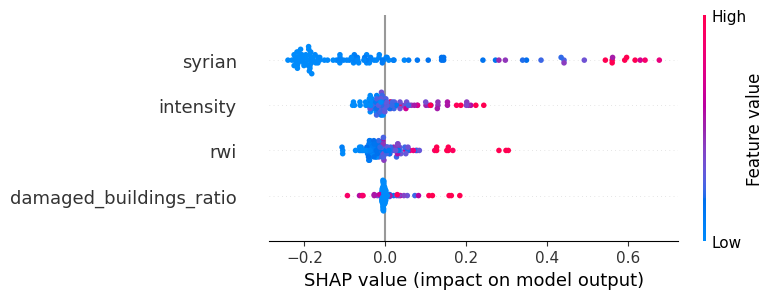

{'Random Forest': {'accuracy': 0.8830511060259344,
  'precision': 0.8180537634408603,
  'recall': 0.7483878932408345,
  'f1': 0.7786755534201856,
  'roc_auc': 0.9182716265014748,
  'confusion_matrix': array([[389,  26],
         [ 41, 117]], dtype=int64)}}

In [240]:
features_list3 = [
    'city_category2_log',
]
x_features=['intensity','syrian', 'rwi','damaged_buildings_ratio']
models = {
    'Random Forest': RandomForestClassifier(),
}

model_types = {
    'Random Forest': 'Random Forest',
}

results6 = shap_analyze(model_types, city_features_dict, flow_s ,x_features, models, features_list3, n_splits=5,dataset='syrian')
results6

In [ ]:
{'Random Forest': {'accuracy': 0.8830511060259344,
  'precision': 0.8180537634408603,
  'recall': 0.7483878932408345,
  'f1': 0.7786755534201856,
  'roc_auc': 0.9182716265014748,
  'confusion_matrix': array([[389,  26],
         [ 41, 117]], dtype=int64)}}